In [9]:
from jax_renderer_primitives import getProjectionMatrixJax, _build_rasterize_gaussians_fwd_primitive
from diff_gaussian_rasterization import _C as torch_backend

import jax
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
import functools
import matplotlib.pyplot as plt
import math
import numpy as np
from random import randint
from tqdm import tqdm
from time import time
import torch

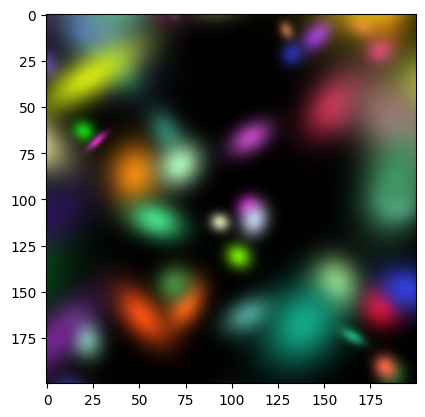

In [8]:
key = jax.random.PRNGKey(5)
N = 100
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)
cov3D_precomp = jax.random.uniform(jax.random.PRNGKey(1), shape=(N,3), minval=0.0, maxval=0.1)
# sh = jax.random.uniform(jax.random.PRNGKey(default_seed), shape=(N,0), minval=0.0, maxval=1.0)
sh_jax = jnp.array([])

image_width, image_height, fx, fy, cx, cy, znear, zfar = 200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
pmatrix = getProjectionMatrixJax(image_width, image_height, fx, fy, cx, cy, znear, zfar)
camera_pose_jax = jnp.eye(4)
view_matrix = jnp.transpose(jnp.linalg.inv(jnp.eye(4)))

projmatrix = view_matrix @ pmatrix

fovX = jnp.arctan(image_width / 2 / fx) * 2.0
fovY = jnp.arctan(image_height / 2 / fy) * 2.0
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)

bg = jnp.zeros(3)
campos = jnp.zeros(3)
rasterizer_fwd_jax = _build_rasterize_gaussians_fwd_primitive()

num_rendered_jax, color_jax, radii_jax, geomBuffer_jax, binningBuffer_jax, imgBuffer_jax = rasterizer_fwd_jax.bind(
            bg,
            means3D,
            colors_precomp,
            opacity,
            scales,
            rotations,
            view_matrix,
            projmatrix,
            campos,
            tanfovx=tan_fovx, 
            tanfovy=tan_fovy, 
            image_height=image_height, 
            image_width=image_width,  
)
fix, (ax1) = plt.subplots(1, 1)
ax1.imshow(jnp.transpose(color_jax, (1,2,0)))

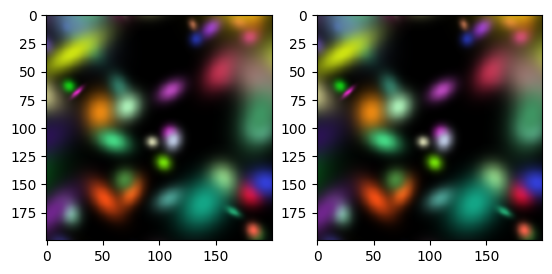

In [14]:
def torch_to_jax(torch_array):
    return jnp.array(torch_array.detach().cpu().numpy())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic=True


def jax_to_torch(jnp_array):
    return torch.tensor(np.array(jnp_array), requires_grad=True, device=device)

sh_degree = 0
torch_fwd_args = (
    jax_to_torch(bg), 
    jax_to_torch(means3D),
    jax_to_torch(colors_precomp),
    jax_to_torch(opacity),
    jax_to_torch(scales),
    jax_to_torch(rotations),
    1.0,
    torch.Tensor([]),
    jax_to_torch(view_matrix),
    jax_to_torch(projmatrix),
    tan_fovx,
    tan_fovy,
    image_height,
    image_width,
    torch.Tensor([]),
    sh_degree,
    jax_to_torch(campos),
    False,
    False
)

num_rendered_torch, color_torch, radii_torch, geomBuffer_torch, binningBuffer_torch, imgBuffer_torch = torch_backend.rasterize_gaussians(*torch_fwd_args)
color_torch = color_torch.detach()
color_torch_jax = torch_to_jax(color_torch)
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color_jax, (1,2,0)))
ax2.imshow(jnp.transpose(color_torch_jax, (1,2,0)))

assert num_rendered_torch == int(num_rendered_jax[0]), "num_rendered mismatch"
assert jnp.allclose(color_torch_jax, color_jax), "color mismatch"
assert jnp.allclose(torch_to_jax(radii_torch), radii_jax), "radii mismatch"